これはwindows11proで実行する用のファイルです。[CUDA=11.2.2 GPU_driver=<546.33 cuDNN=8.1

ここではライブラリのインポートとバージョン確認を確認している。

In [1]:
# インポート
import os
import glob
import argparse
import numpy as np
import zipfile
import time
import datetime

import sklearn  
from sklearn.model_selection import train_test_split

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import cv2

import tensorflow as tf

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, Conv2D
from tensorflow.keras import optimizers

# from common_flags import FLAGS
from tensorflow.keras.utils import plot_model, to_categorical

#package modul version 表示

print("tensorflow: ", tf.__version__)# 2023/01/13 時点 ver. 2.9.2
print("numpy: ", np.__version__)
print("pandas: ", pd.__version__)
print("sklearn (for train_test_split): ", sklearn.__version__)
print("matplotlib (for pyplot): ", matplotlib.__version__)
print("opencv (cv2): ", cv2.__version__)
print("tensorflow-gpu: ", tf.test.is_built_with_cuda())

!python -V

tensorflow:  2.9.2
numpy:  1.24.3
pandas:  1.5.3
sklearn (for train_test_split):  1.2.2
matplotlib (for pyplot):  3.7.1
opencv (cv2):  4.8.0
tensorflow-gpu:  True
Python 3.8.18


GPUの認識に問題ないかを確認する。
エラーがある場合は e　が表示される。　

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # メモリ成長を有効にする
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


畳み込みニューラルネットワークと深層型ニューラルネットワークの構造を定義する。

In [3]:
# 訓練用ニューラルネットワーク定義
def cnn(input_shape):
    drop = 0.5
    # Input
    img_input = Input(shape=(input_shape), name='input')
    x1 = Conv2D(24, (5,5), strides=(2,2), activation='relu', name="conv2d_1")(img_input)
    x2 = Conv2D(32, (5,5), strides=(2,2), activation='relu', name="conv2d_2")(x1)
    x3 = Conv2D(64, (5,5), strides=(2,2), activation='relu', name="conv2d_3")(x2)
    x4 = Conv2D(64, (3,3), strides=(2,2), activation='relu', name="conv2d_4")(x3)
    x5 = Conv2D(64, (3,3), strides=(1,1), activation='relu', name="conv2d_5")(x4)



    ##全結合層の定義
    x6 = Flatten(name='flattened')(x5)
    x7 = Dense(100, activation='relu', name="fc_1")(x6)
    x8 = Dropout(0.5 , name="Dropout_1")(x7)

    x9 = Dense(50, activation='relu', name="fc_2")(x8)
    x10 = Dropout(0.5, name="Dropout_2")(x9)

    x11 = Dense(20, activation='relu', name="fc_3")(x6)
    x12 = Dropout(0.5, name="Dropout_3")(x11)

    ##出力層
    output1 = Dense(1, activation='linear', name='output1')(x10)
    output2 = Dense(1, activation='linear', name='output2')(x12)

   ##出力２に対して入力Ⅰの定義 output1 steer output2 throttle
    model = Model(inputs=[img_input], outputs=[output1, output2])

    return model

ニューラルネットワークの訓練結果を表示するプログラム。

In [4]:
#グラフを一つにまとめた
def plot_history_loss(history):
    plt.figure(figsize=(10, 6))

    # ステアリング損失（トレーニングとバリデーション）
    plt.plot(history.history['output1_loss'], label='Steer loss for training', color='blue')
    plt.plot(history.history['val_output1_loss'], label='Steer loss for validation', color='cyan')

    # スロットル損失（トレーニングとバリデーション）
    plt.plot(history.history['output2_loss'], label='Throttle loss for training', color='red')
    plt.plot(history.history['val_output2_loss'], label='Throttle loss for validation', color='magenta')

    # グラフの設定
    plt.xlabel('Epochs', fontsize=22)
    plt.ylabel('Loss', fontsize=22)
    plt.legend(loc='best', fontsize=22)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True)

    plt.savefig('./01_combined_loss.png')
    plt.show()
    plt.close()

画像と正解ラベルを取り出すための定義を行う。

In [5]:
# 訓練時の画像サイズ
image_width = 160         
image_height = 120

# 訓練画像を読み込む関数
def load_images(input_dir, X, Y, Z):
    img_list = pd.read_csv(input_dir + '/list2.txt', header=None, delim_whitespace=True)
    image_path = input_dir + '/images/' + img_list[0]

    # 画像データの読み込み
    for index, file_name in enumerate(image_path):
        image = cv2.imread(file_name)
        resize_image = cv2.resize(image, (image_width, image_height))
        data = np.asarray(resize_image)
        X.append(data)
        Y.append(img_list[1][index])
        Z.append(img_list[2][index])
    return X, Y, Z

先ほど定義したload_imagesからデータを取り出し、学習させる。

In [6]:
# メイン関数の定義　callbackがあるバージョン
def _main():
    X = []
    Y = []
    Z = []
    X, Y, Z =load_images("./6_image_data", X, Y, Z) # images_dataの読み込み
    X, Y, Z=load_images("./7_image_data", X, Y, Z) # images_dataの読み込み
    X, Y, Z=load_images("./8_image_data", X, Y, Z) # images_dataの読み込み
    X, Y, Z=load_images("./9_image_data", X, Y, Z) # images_dataの読み込み

    X = np.array(X)
    Y = np.array(Y)
    Z = np.array(Z)

    X = X.astype('float32')#画像データを0から1の範囲に変換 これを正規化という画像値は0~255の値をとる
    X = X / 255.0
    Y = Y.astype('float32')# 正解データ（steer）の微調整
    Z = Z.astype('float32')# 正解データ（thorottle）の微調整
    # 学習用データとテストデータ
    X_train, X_test, Y_train, Y_test, Z_train, Z_test = train_test_split(X, Y, Z, test_size=0.20) #0.20なら20%がテストデータ
    shape = X_train.shape[1:]
    model = cnn(shape)
    # ハイパーパラメータ
    decay = 1e-6
    lr = 1e-3
    batch_size = 16
    epochs = 15
    loss_weights = [1,1]
    #コールバックの設定
    early_stpping_callback = tf.keras.callbacks.EarlyStopping(
        monitor ='val_loss',
        patience = 20,
        verbose = 2,
        mode = 'min',
        restore_best_weights = True
    )
    # コンパイル
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = lr, decay = decay),
                loss={'output1': tf.keras.losses.huber,
                      'output2': tf.keras.losses.huber},
                loss_weights = loss_weights,
                )
    # 訓練
    history = model.fit(x =  X_train,
                        y = {'output1': Y_train, 'output2': Z_train},
                        batch_size = batch_size,
                        epochs = epochs,
                        verbose = 2,
                        validation_data = ({'input': X_test}, {'output1': Y_test, 'output2': Z_test}),
                        callbacks = [early_stpping_callback],
                       )

    # モデルの保存
    model.save('./17Stopping_model.h5')
    # 評価 & 評価結果出力
    #print(model.evaluate(X_test, {'output1': Y_test, 'output2': Z_test}))
    # モデルの図示化
    #plot_model(model, to_file='./17Stopping_model.png', show_shapes=True)
    # 評価 & 評価結果出力
    #print(model.evaluate(X_test, {'output1': Y_test, 'output2': Z_test}))
    plot_history_loss(history)# show result graph

Epoch 1/15
2692/2692 - 22s - loss: 7.3687 - output1_loss: 5.4286 - output2_loss: 1.9401 - val_loss: 5.2048 - val_output1_loss: 4.2857 - val_output2_loss: 0.9191 - 22s/epoch - 8ms/step
Epoch 2/15
2692/2692 - 12s - loss: 5.9780 - output1_loss: 4.6181 - output2_loss: 1.3599 - val_loss: 4.8108 - val_output1_loss: 4.1028 - val_output2_loss: 0.7080 - 12s/epoch - 5ms/step
Epoch 3/15
2692/2692 - 12s - loss: 5.4370 - output1_loss: 4.2726 - output2_loss: 1.1644 - val_loss: 3.7828 - val_output1_loss: 3.4881 - val_output2_loss: 0.2948 - 12s/epoch - 5ms/step
Epoch 4/15
2692/2692 - 12s - loss: 5.0361 - output1_loss: 4.0357 - output2_loss: 1.0004 - val_loss: 3.6451 - val_output1_loss: 3.2479 - val_output2_loss: 0.3972 - 12s/epoch - 5ms/step
Epoch 5/15
2692/2692 - 12s - loss: 4.6949 - output1_loss: 3.8307 - output2_loss: 0.8642 - val_loss: 3.2881 - val_output1_loss: 3.0318 - val_output2_loss: 0.2562 - 12s/epoch - 4ms/step
Epoch 6/15
2692/2692 - 13s - loss: 4.4703 - output1_loss: 3.7130 - output2_loss:

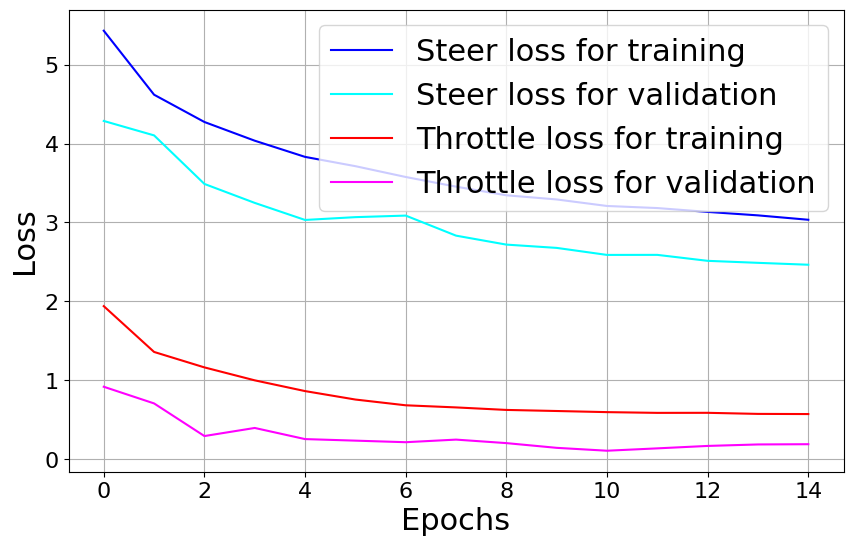

In [7]:
_main()